## SQL at Scale with Spark SQL and DataFrames

Spark SQL brings native support for SQL to Spark and streamlines the process of querying data stored both in RDDs (Spark’s distributed datasets) and in external sources. Spark SQL conveniently blurs the lines between RDDs and relational tables. Unifying these powerful abstractions makes it easy for developers to intermix SQL commands querying external data with complex analytics, all within in a single application. Concretely, Spark SQL will allow developers to:

- Import relational data from Parquet files and Hive tables
- Run SQL queries over imported data and existing RDDs
- Easily write RDDs out to Hive tables or Parquet files

Spark SQL also includes a cost-based optimizer, columnar storage, and code generation to make queries fast. At the same time, it scales to thousands of nodes and multi-hour queries using the Spark engine, which provides full mid-query fault tolerance, without having to worry about using a different engine for historical data.

_For getting a deeper perspective into the background, concepts, architecture of Spark SQL and DataFrames you can check out the original article, __['SQL at Scale with Apache Spark SQL and DataFrames - Concepts, Architecture and Examples'](https://medium.com/p/c567853a702f)___

This tutorial will familiarize you with essential Spark capabilities to deal with structured data typically often obtained from databases or flat files. We will explore typical ways of querying and aggregating relational data by leveraging concepts of DataFrames and SQL using Spark. We will work on an interesting dataset from the [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) and try to query the data using high level abstrations like the dataframe which has already been a hit in popular data analysis tools like R and Python. We will also look at how easy it is to build data queries using the SQL language which you have learnt and retrieve insightful information from our data. This also happens at scale without us having to do a lot more since Spark distributes these data structures efficiently in the backend which makes our queries scalable and as efficient as possible.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Data Retrieval

We will use data from the [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html), which is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

We will be using the reduced dataset `kddcup.data_10_percent.gz` containing nearly half million nework interactions since we would be downloading this Gzip file from the web locally and then work on the same. If you have a good, stable internet connection, feel free to download and work with the full dataset available as `kddcup.data.gz`

#### Working with data from the web

Dealing with datasets retrieved from the web can be a bit tricky in Databricks. Fortunately, we have some excellent utility packages like `dbutils` which help in making our job easier. Let's take a quick look at some essential functions for this module.

In [0]:
dbutils.help()

#### Retrieve and store data in Databricks

We will now leverage the python `urllib` library to extract the KDD Cup 99 data from their web repository, store it in a temporary location and then move it to the Databricks filesystem which can enable easy access to this data for analysis

__Note:__ If you skip this step and download the data directly, you may end up getting a `InvalidInputException: Input path does not exist` error

In [0]:
import urllib.request
urllib.request.urlretrieve("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "/tmp/kddcup_data.gz")
dbutils.fs.mv("file:/tmp/kddcup_data.gz", "dbfs:/kdd/kddcup_data.gz")
display(dbutils.fs.ls("dbfs:/kdd"))

path,name,size
dbfs:/kdd/kddcup_data.gz,kddcup_data.gz,2144903


## Building the KDD Dataset

Now that we have our data stored in the Databricks filesystem. Let's load up our data from the disk into Spark's traditional abstracted data structure, the [Resilient Distributed Dataset (RDD)](https://spark.apache.org/docs/latest/rdd-programming-guide.html#resilient-distributed-datasets-rdds)

In [0]:
data_file = "dbfs:/kdd/kddcup_data.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(5)

Out[2]: ['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [0]:
type(raw_rdd)

Out[3]: pyspark.rdd.RDD

## Building a Spark DataFrame on our Data

A Spark DataFrame is an interesting data structure representing a distributed collecion of data. A DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a dataframe in R/Python, but with richer optimizations under the hood. DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs in our case.

Typically the entry point into all SQL functionality in Spark is the `SQLContext` class. To create a basic instance of this call, all we need is a `SparkContext` reference. In Databricks this global context object is available as `sc` for this purpose.

In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
sqlContext 

Out[4]: <pyspark.sql.context.SQLContext at 0x7f306c6d9f10>

#### Splitting the CSV data
Each entry in our RDD is a comma-separated line of data which we first need to split before we can parse and build our dataframe

In [0]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
print(csv_rdd.take(1))
print(type(csv_rdd))

[['0', 'tcp', 'http', 'SF', '181', '5450', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '9', '9', '1.00', '0.00', '0.11', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']]
<class 'pyspark.rdd.PipelinedRDD'>

#### Check the total number of features (columns)
We can use the following code to check the total number of potential columns in our dataset

In [0]:
len(csv_rdd.take(1)[0])

Out[6]: 42

#### Data Understanding and Parsing

The KDD 99 Cup data consists of different attributes captured from connection data. The full list of attributes in the data can be obtained [__here__](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names) and further details pertaining to the description for each attribute\column can be found [__here__](http://kdd.ics.uci.edu/databases/kddcup99/task.html). We will just be using some specific columns from the dataset, the details of which are specified below.


| feature num | feature name       | description                                                  | type       |
|-------------|--------------------|--------------------------------------------------------------|------------|
| 1           | duration           | length (number of seconds) of the connection                 | continuous |
| 2           | protocol_type      | type of the protocol, e.g. tcp, udp, etc.                    | discrete   |
| 3           | service            | network service on the destination, e.g., http, telnet, etc. | discrete   |
| 4           | src_bytes          | number of data bytes from source to destination              | continuous |
| 5           | dst_bytes          | number of data bytes from destination to source              | continuous |
| 6           | flag               | normal or error status of the connection                     | discrete   |
| 7           | wrong_fragment     | number of ``wrong'' fragments                                | continuous |
| 8           | urgent             | number of urgent packets                                     | continuous |
| 9           | hot                | number of ``hot'' indicators                                 | continuous |
| 10          | num_failed_logins  | number of failed login attempts                              | continuous |
| 11          | num_compromised    | number of ``compromised'' conditions                         | continuous |
| 12          | su_attempted       | 1 if ``su root'' command attempted; 0 otherwise              | discrete   |
| 13          | num_root           | number of ``root'' accesses                                  | continuous |
| 14          | num_file_creations | number of file creation operations                           | continuous |

We will be extracting the following columns based on their positions in each datapoint (row) and build a new RDD as follows

In [0]:
from pyspark.sql import Row

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

Out[7]: [Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=181, dst_bytes=5450, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=239, dst_bytes=486, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=235, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=219, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=217, dst_bytes=2032, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.')]

#### Constructing the DataFrame
Now that our data is neatly parsed and formatted, let's build our DataFrame!

In [0]:
df = sqlContext.createDataFrame(parsed_rdd)
display(df.head(10))

duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,label
0,tcp,http,SF,181,5450,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,219,1337,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,212,1940,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,159,4087,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,210,151,0,0,0,0,0,0,0,0,normal.
0,tcp,http,SF,212,786,0,0,1,0,0,0,0,0,normal.


Now, we can easily have a look at our dataframe's schema using tne `printSchema(...)` function.

In [0]:
df.printSchema()

## Building a temporary table 

We can leverage the `registerTempTable()` function to build a temporaty table to run SQL commands on our DataFrame at scale! A point to remember is that the lifetime of this temp table is tied to the session. It creates an in-memory table that is scoped to the cluster in which it was created. The data is stored using Hive's highly-optimized, in-memory columnar format. 

You can also check out `saveAsTable()` which creates a permanent, physical table stored in S3 using the Parquet format. This table is accessible to all clusters. The table metadata including the location of the file(s) is stored within the Hive metastore.`

In [0]:
help(df.registerTempTable)

In [0]:
df.registerTempTable("connections")

## Executing SQL at Scale
Let's look at a few examples of how we can run SQL queries on our table based off our dataframe. We will start with some simple queries and then look at aggregations, filters, sorting, subqueries and pivots

### Connections based on the protocol type

Let's look at how we can get the total number of connections based on the type of connectivity protocol. First we will get this information using normal DataFrame DSL syntax to perform aggregations.

In [0]:
display(df.groupBy('protocol_type')
          .count()
          .orderBy('count', ascending=False))

protocol_type,count
icmp,283602
tcp,190065
udp,20354


Can we also use SQL to perform the same aggregation? Yes we can leverage the table we built earlier for this!

In [0]:
protocols = sqlContext.sql("""
                           SELECT protocol_type, count(*) as freq
                           FROM connections
                           GROUP BY protocol_type
                           ORDER BY 2 DESC
                           """)
display(protocols)

protocol_type,freq
icmp,283602
tcp,190065
udp,20354


You can clearly see, that you get the same results and you do not need to worry about your background infrastructure or how the code is executed. Just write simple SQL!

### Connections based on good or bad (attack types) signatures

We will now run a simple aggregation to check the total number of connections based on good (normal) or bad (intrusion attacks) types.

In [0]:
labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
display(labels)

label,freq
smurf.,280790
neptune.,107201
normal.,97278
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979
pod.,264


We have a lot of different attack types. We can visualize this in the form of a bar chart. The simplest way is to use the excellent interface options in the Databricks notebook itself as depicted in the following figure!

![](https://cdn-images-1.medium.com/max/800/1*MWtgLR6H4siUB1Ugc8sqog.png)

This gives us the following nice looking bar chart! Which you can customize further by clicking on __`Plot Options`__ as needed.

In [0]:
labels = sqlContext.sql("""
                           SELECT label, count(*) as freq
                           FROM connections
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)
display(labels)

label,freq
smurf.,280790
neptune.,107201
normal.,97278
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979
pod.,264


Another way is to write the code yourself to do it. You can extract the aggregated data as a `pandas` DataFrame and then plot it as a regular bar chart.

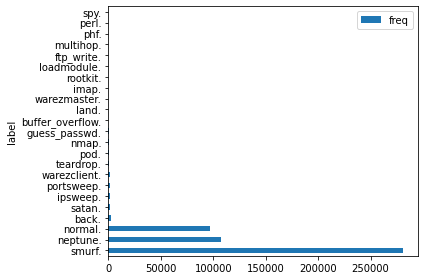

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
labels_df = pd.DataFrame(labels.toPandas())
labels_df.set_index("label", drop=True,inplace=True)
labels_fig = labels_df.plot(kind='barh')

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
display(labels_fig.figure)

### Connections based on protocols and attacks

Let's look at which protocols are most vulnerable to attacks now based on the following SQL query.

In [0]:
attack_protocol = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
display(attack_protocol)

protocol_type,state,freq
icmp,attack,282314
tcp,attack,113252
tcp,no attack,76813
udp,no attack,19177
icmp,no attack,1288
udp,attack,1177


Well, looks like ICMP connections followed by TCP connections have had the maximum attacks!

### Connection stats based on protocols and attacks

Let's take a look at some statistical measures pertaining to these protocols and attacks for our connection requests.

In [0]:
attack_stats = sqlContext.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
display(attack_stats)

protocol_type,state,total_freq,mean_src_bytes,mean_dst_bytes,mean_duration,total_failed_logins,total_compromised,total_file_creations,total_root_attempts,total_root_acceses
icmp,attack,282314,932.14,0.0,0.0,0,0,0,0.0,0
tcp,attack,113252,9880.38,881.41,23.19,57,2269,76,1.0,152
tcp,no attack,76813,1439.31,4263.97,11.08,18,2776,459,17.0,5456
udp,no attack,19177,98.01,89.89,1054.63,0,0,0,0.0,0
icmp,no attack,1288,91.47,0.0,0.0,0,0,0,0.0,0
udp,attack,1177,27.5,0.23,0.0,0,0,0,0.0,0


Looks like average amount of data being transmitted in TCP requests are much higher which is not surprising. Interestingly attacks have a much higher average payload of data being transmitted from the source to the destination.

#### Filtering connection stats based on the TCP protocol by service and attack type

Let's take a closer look at TCP attacks given that we have more relevant data and statistics for the same. We will now aggregate different types of TCP attacks based on service, attack type and observe different metrics.

In [0]:
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq,mean_duration,total_failed_logins,total_file_creations,total_root_attempts,total_root_acceses
private,neptune.,101317,0.0,0,0,0.0,0
http,back.,2203,0.13,0,0,0.0,0
other,satan.,1221,0.0,0,0,0.0,0
private,portsweep.,725,1915.81,0,0,0.0,0
ftp_data,warezclient.,708,403.71,0,0,0.0,0
ftp,warezclient.,307,1063.79,0,0,0.0,0
other,portsweep.,260,1058.22,0,0,0.0,0
telnet,neptune.,197,0.0,0,0,0.0,0
http,neptune.,192,0.0,0,0,0.0,0
finger,neptune.,177,0.0,0,0,0.0,0


There are a lot of attack types and the preceding output shows a specific section of the same.

### Filtering connection stats based on the TCP protocol by service and attack type

We will now filter some of these attack types by imposing some constraints based on duration, file creations, root accesses in our query.

In [0]:
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE (protocol_type = 'tcp'
                                          AND label != 'normal.')
                                   GROUP BY service, attack_type
                                   HAVING (mean_duration >= 50
                                           AND total_file_creations >= 5
                                           AND total_root_acceses >= 1)
                                   ORDER BY total_freq DESC
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq,mean_duration,total_failed_logins,total_file_creations,total_root_attempts,total_root_acceses
telnet,buffer_overflow.,21,130.67,0,15,0.0,5
telnet,loadmodule.,5,63.8,0,9,0.0,3
telnet,multihop.,2,458.0,0,8,0.0,93


Interesting to see multihop attacks being able to get root accesses to the destination hosts!

### Subqueries to filter TCP attack types based on service

Let's try to get all the TCP attacks based on service and attack type such that the overall mean duration of these attacks is greater than zero (`> 0`). For this we can do an inner query with all aggregation statistics and then extract the relevant queries and apply a mean duration filter in the outer query as shown below.

In [0]:
tcp_attack_stats = sqlContext.sql("""
                                   SELECT 
                                     t.service,
                                     t.attack_type,
                                     t.total_freq
                                   FROM
                                   (SELECT 
                                     service,
                                     label as attack_type,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC) as t
                                     WHERE t.mean_duration > 0 
                                   """)
display(tcp_attack_stats)

service,attack_type,total_freq
http,back.,2203
private,portsweep.,725
ftp_data,warezclient.,708
ftp,warezclient.,307
other,portsweep.,260
private,satan.,170
telnet,guess_passwd.,53
telnet,buffer_overflow.,21
ftp_data,warezmaster.,18
imap4,imap.,12


This is nice! Now an interesting way to also view this data is to use a pivot table where one attribute represents rows and another one represents columns. Let's see if we can leverage Spark DataFrames to do this!

### Building a Pivot Table from Aggregated Data

Here, we will build upon the previous DataFrame object we obtained where we aggregated attacks based on type and service. For this, we can leverage the power of Spark DataFrames and the DataFrame DSL.

In [0]:
display((tcp_attack_stats.groupby('service')
                         .pivot('attack_type')
                         .agg({'total_freq':'max'})
                         .na.fill(0))
)

We get a nice neat pivot table showing all the occurences based on service and attack type!

There are plenty of articles\tutorials available online so I would recommend you to check them out. Some useful resources for you to check out include, [the complete guide to Spark SQL from Databricks](https://docs.databricks.com/spark/latest/spark-sql/index.html).